# import lib

In [35]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy.ndimage.measurements import label
import numpy as np
import cv2
import glob
import time
import pickle
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import deque
from lesson_functions import *
%matplotlib inline

# read files

8792
8968
1758
1793


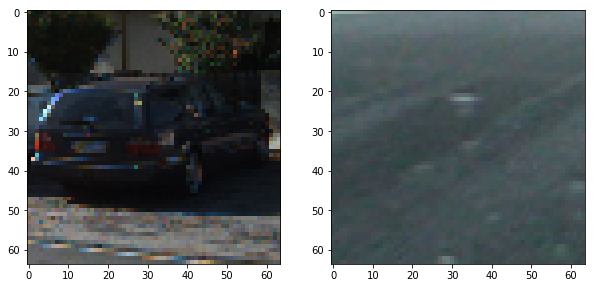

In [28]:
cars = glob.glob('datas/vehicles/**/*.png')
notcars = glob.glob('datas/non-vehicles/**/*.png')
print(len(cars))
print(len(notcars))
cars = random.sample(cars, int(len(cars)/5))
notcars = random.sample(notcars, int(len(notcars)/5))
print(len(cars))
print(len(notcars))      
car_image = mpimg.imread(cars[10])
notcar_image = mpimg.imread(notcars[0])

f,(ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.imshow(car_image)
ax2.imshow(notcar_image)

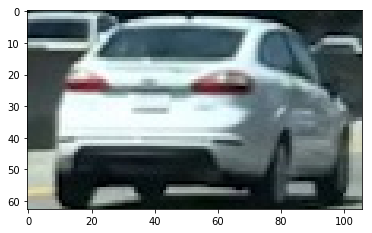

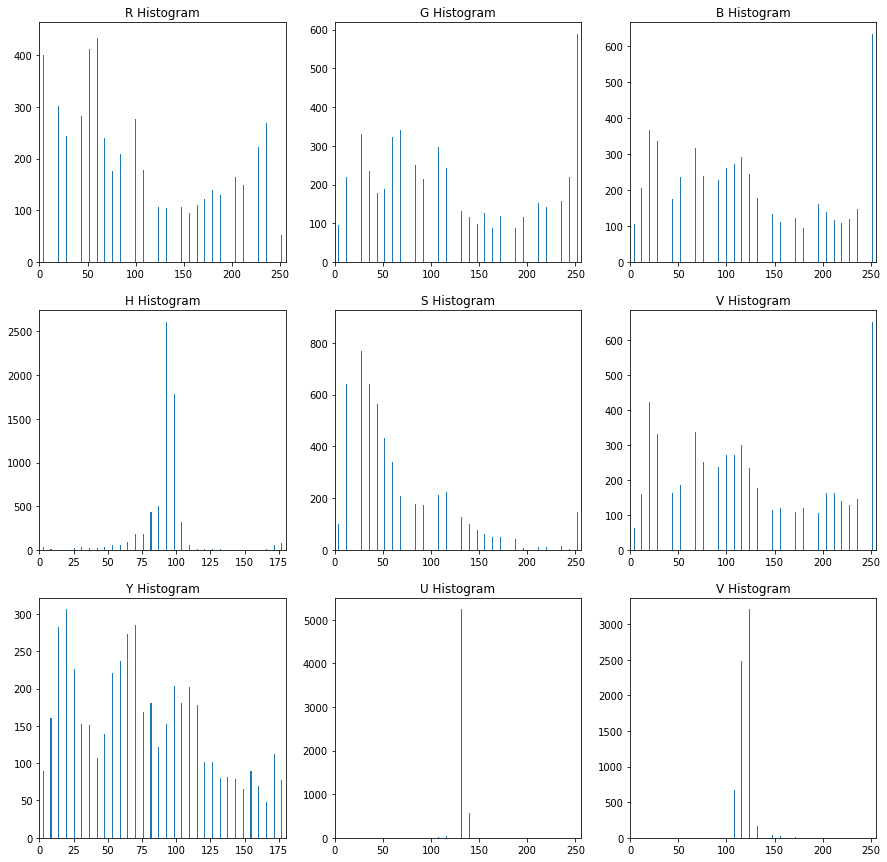

In [30]:
def draw_histogram(image_rgb):
    rhist = np.histogram(image_rgb[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image_rgb[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image_rgb[:,:,2], bins=32, range=(0, 256))
    
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    fig = plt.figure(figsize=(15,15))
    plt.subplot(331)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(332)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(333)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    
    imgage_hsv = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2HSV)
    hhist = np.histogram(imgage_hsv[:,:,0], bins=32, range=(0, 180))
    shist = np.histogram(imgage_hsv[:,:,1], bins=32, range=(0, 256))
    vhist = np.histogram(imgage_hsv[:,:,2], bins=32, range=(0, 256))
    
    h_bin_edges = hhist[1]
    h_bin_centers = (h_bin_edges[1:]  + h_bin_edges[0:len(h_bin_edges)-1])/2

    
    plt.subplot(334)
    plt.bar(h_bin_centers, hhist[0])
    plt.xlim(0, 180)
    plt.title('H Histogram')
    plt.subplot(335)
    plt.bar(bin_centers, shist[0])
    plt.xlim(0, 256)
    plt.title('S Histogram')
    plt.subplot(336)
    plt.bar(bin_centers, vhist[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    
    
    imgage_yuv = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2YUV)
    yhist = np.histogram(imgage_yuv[:,:,0], bins=32, range=(0, 180))
    uhist = np.histogram(imgage_yuv[:,:,1], bins=32, range=(0, 256))
    vhist = np.histogram(imgage_yuv[:,:,2], bins=32, range=(0, 256))
    
    h_bin_edges = hhist[1]
    h_bin_centers = (h_bin_edges[1:]  + h_bin_edges[0:len(h_bin_edges)-1])/2

    
    plt.subplot(337)
    plt.bar(h_bin_centers, yhist[0])
    plt.xlim(0, 180)
    plt.title('Y Histogram')
    plt.subplot(338)
    plt.bar(bin_centers, uhist[0])
    plt.xlim(0, 256)
    plt.title('U Histogram')
    plt.subplot(339)
    plt.bar(bin_centers, vhist[0])
    plt.xlim(0, 256)
    plt.title('V Histogram')
    
im = plt.imread('datas/cutout1.jpg')
plt.imshow(im)
draw_histogram(im)

# extract features

In [36]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

set `block_norm=L1` is better than `block_norm=L2-Hys`

In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L1',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L1',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        
        return features

In [8]:
# a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      


        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        ch1 = feature_image[:,:,0]
        ch2 = feature_image[:,:,1]
        ch3 = feature_image[:,:,2]
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog_features = np.hstack((hog1, hog2, hog3)).ravel()
        
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))

    return features

In [5]:

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


# Normalize

In [ ]:
X = np.vstack((car_features, notcar_features))             
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# train

In [7]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Feature vector length: 11988
1.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9944


In [8]:
obj = {"svc":svc,"X_scaler":X_scaler}
pickle.dump(obj, open("model.pickle", "wb"))

In [37]:
obj = pickle.load(open("model.pickle", "rb"))
svc = obj['svc']
X_scaler = obj['X_scaler']

In [38]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,draw_all=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or draw_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return draw_img, bboxes


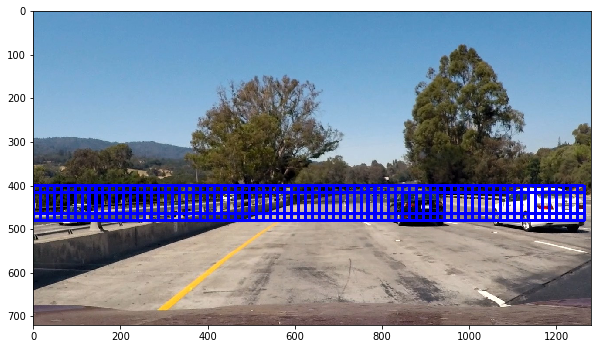

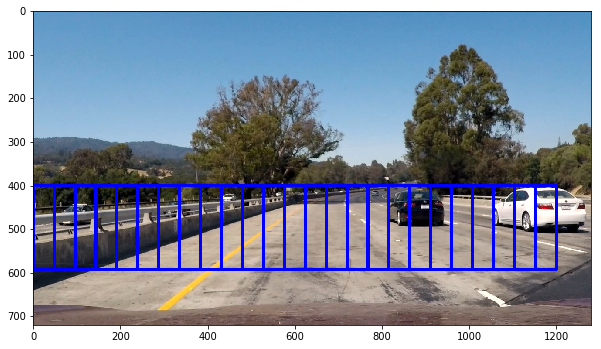

In [45]:
image1 = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 500 
out_img1, bboxes1 = find_cars(image1, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,True)
ystart = 400 
ystop = 656 
out_img2, bboxes10 = find_cars (image1, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,True)
f = plt.figure(figsize=(10,10))
plt.imshow(out_img1)
plt.show()
f = plt.figure(figsize=(10,10))
plt.imshow(out_img2)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


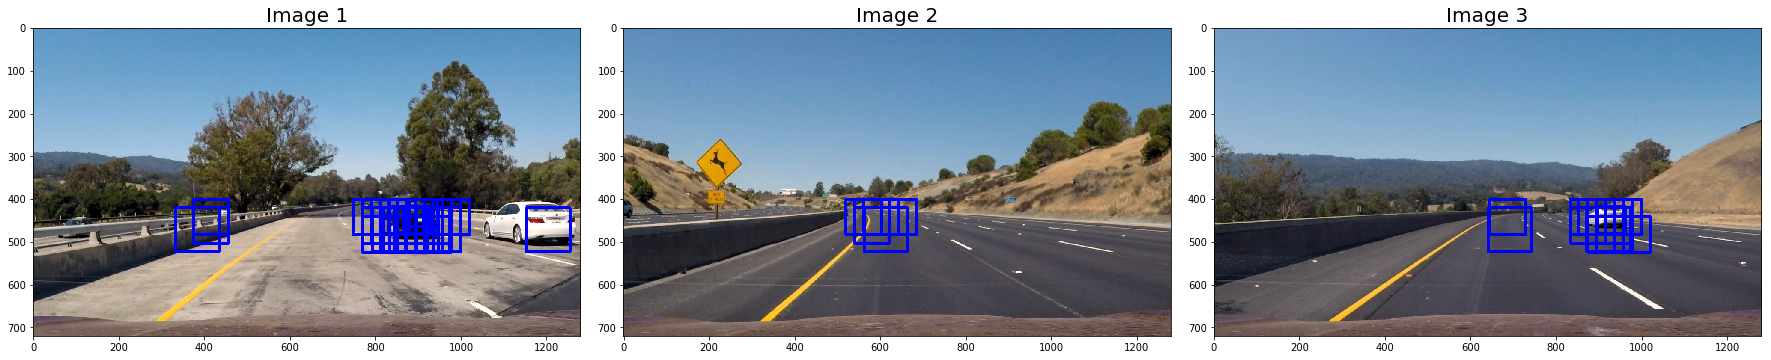

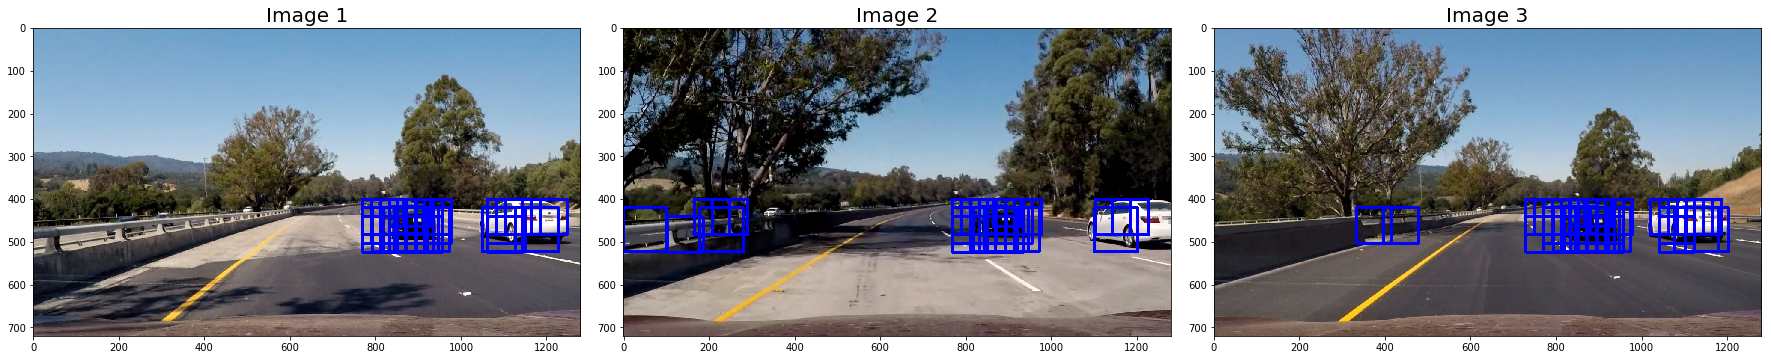

In [18]:

def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    
    return out_img, bboxes
   
image1 = mpimg.imread('./test_images/test1.jpg')
image2 = mpimg.imread('./test_images/test2.jpg')
image3 = mpimg.imread('./test_images/test3.jpg')
image4 = mpimg.imread('./test_images/test4.jpg')
image5 = mpimg.imread('./test_images/test5.jpg')
image6 = mpimg.imread('./test_images/test6.jpg')

output_image1, bboxes1 = apply_sliding_window(image1, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image2, bboxes2 = apply_sliding_window(image2, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image3, bboxes3 = apply_sliding_window(image3, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image4, bboxes4 = apply_sliding_window(image4, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image5, bboxes5 = apply_sliding_window(image5, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
output_image6, bboxes6 = apply_sliding_window(image6, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

image = mpimg.imread('./test_images/test4.jpg')
draw_image = np.copy(image)
output_image, bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

def show_images(image1, image2, image3,  image1_exp="Image 1", image2_exp="Image 2", image3_exp="Image 3"):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2)
    ax2.set_title(image2_exp, fontsize=20)
    ax3.imshow(image3)
    ax3.set_title(image3_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

show_images(output_image1, output_image2, output_image3)
show_images(output_image4, output_image5, output_image6)

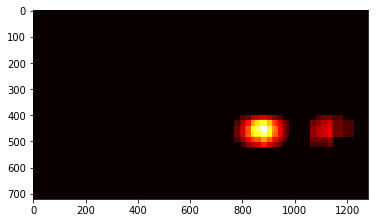

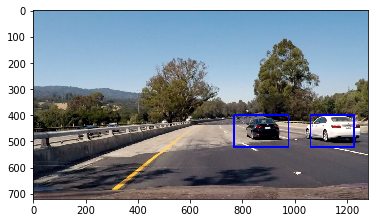

In [19]:
def add_heatmap(image,bboxes,history=[]):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    threshold = 1 
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)
    
    historymap = np.zeros_like(current_heatmap).astype(np.float)
    for aaa in history:
        historymap = historymap + aaa
        
    heatmap = historymap + current_heatmap
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return current_heatmap,draw_img
    
heatmap,draw_img = add_heatmap(image,bboxes)
plt.imshow(heatmap,cmap='hot')
plt.show()
plt.imshow(draw_img)

In [26]:
def detect_car(image):
    out_img, bboxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heatmap,draw_img = add_heatmap(image,bboxes,history)
    history.append(heatmap)
    
    return draw_img

deque([], maxlen=8)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


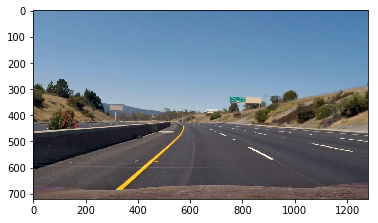

In [21]:
history = deque(maxlen = 7)
image = plt.imread('datas/0.jpg')
img = detect_car(image)
plt.imshow(img)

In [29]:
import imageio
import time
history = deque(maxlen = 7)
timeF = 1

reader = imageio.get_reader('datas/project_video.mp4')

for i, img in enumerate(reader):
    if (i % timeF == 0):
        img = detect_car(img)
        imageio.imwrite('./output/videoimg/'+str(time.time())+'.jpg',img)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [30]:
img_paths = glob.glob("./output/videoimg/*.jpg")

writer = imageio.get_writer('./out.mp4', fps=25)
for img_path in img_paths:
    im = imageio.imread(img_path)
    writer.append_data(im)

writer.close()